# one frequency, variable output length
Easy peasy. Let's see how well:
- A model with a fixed unit count can learn variable-length sinusoids with stable frequencies
- how a model trained to one target length generalizes to other output lengths

In [1]:
from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

import datetime
import os
import sys
import csv
from itertools import product, combinations, combinations_with_replacement
import glob

import pickle as pkl

import argparse
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
class SinDataset(Dataset):
    def __init__(self, freq, dt=0.1, n_ch=2, n_src=20, n_trg=20, amp=0.9):
#         if islist()
        self.freq = freq
        self.amp = amp
        self.dt = dt
        self.n_ch = n_ch
        self.n_src = n_src
        self.n_trg = n_trg

    def __len__(self):
        return self.n_src + self.n_trg

    def __getitem__(self,idx):
        t_out = np.arange(self.n_src+self.n_trg)*self.dt
        data_out = np.zeros((self.n_src+self.n_trg,self.n_ch),dtype=np.float32)
        for k in range(self.n_ch):
            data_out[:,k] = self.amp*np.cos(2*np.pi*self.freq*t_out + np.random.rand()*2*np.pi)
        src = data_out[:self.n_src,:]
        trg = data_out[self.n_src:,:]
        return src, trg

Great! The random loader seems to work pretty well. Now let's make a seq2seq model and see how it learns this prediction problem

In [3]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio):

    model.train()

    epoch_loss = 0
    batch_loss = []

    enc_len = model.encoder.seq_len
    dec_len = model.decoder.seq_len
    n_ch = model.decoder.output_dim

    for i, (src,trg) in enumerate(iterator):
        if np.mod(i+1,1000) == 0:
            print(i,len(iterator))
#         src = batch[:,:enc_len,:]
#         trg = batch[:,enc_len:enc_len+dec_len,:n_ch] # only train to
        if dec_len == 1:
            trg = trg.unsqueeze(1)

        optimizer.zero_grad()
        output, _, _ = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)

        #trg = [batch size, trg len, output dim]
        #output = [batch size, trg len, output dim]

        loss = criterion(output, trg)
        loss.backward()

        # clipping the gradient norm may not be very helpful...
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        
        # compute loss
        epoch_loss += loss.item()
        batch_loss.append(loss.item())

#         bar.update(10*i/10000)

#         if i > 10000:
#             break

    return epoch_loss, np.array(batch_loss)

In [4]:
def evaluate(model, iterator, criterion, plot_flag=False):

    model.eval()

    epoch_loss = 0
    batch_loss = []

    enc_len = model.encoder.seq_len
    dec_len = model.decoder.seq_len

    n_ch = model.decoder.output_dim # rename to *_dim?
    n_h_ch = model.encoder.hid_dim

    batch_size = iterator.batch_size

    with torch.no_grad():
#         widgets = [pb.Percentage(), progressbar.Bar()]
#         bar = pb.ProgressBar(widgets=widgets).start()
#         i = 0
        if plot_flag:
            src_ = torch.zeros(len(iterator),enc_len,n_ch)
            src_dx_ = torch.zeros(len(iterator),enc_len,n_ch)
            trg_ = torch.zeros(len(iterator),dec_len,n_ch)
            out_ = torch.zeros(len(iterator),dec_len,n_ch)
            enc_ = torch.zeros(len(iterator),enc_len,n_h_ch)
            dec_ = torch.zeros(len(iterator),dec_len,n_h_ch)

        for i, (src,trg) in enumerate(iterator):

            if np.mod(i+1,1000)==0:
                print(i,len(iterator))
            if dec_len == 1:
                trg = trg.unsqueeze(1)

            output, enc_state, dec_state = model(src, trg, teacher_forcing_ratio=0.) #turn off teacher forcing
            if plot_flag:
                src_[i,] = src[:,:,:n_ch]
                if src.shape[-1] > n_ch:
                    src_dx_[i,] = src[:,:,n_ch:]
                else:
                    src_dx_[i,] = 0. # works?
                trg_[i,] = trg
                out_[i,] = output
                enc_[i,] = enc_state
                dec_[i,] = dec_state

            #trg = [batch size, trg len]
            #output = [batch size, trg len, output dim]
            output_dim = output.shape[-1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            batch_loss.append(loss.item())

        plot_output = []
        if plot_flag:
            # print('num batch:\t{}'.format(num_batch))
            # print(src.size(),trg.size(),output.size())
            for k in range(len(src_)):
                plot_output.append((src_[k,],src_dx_[k,],trg_[k,],out_[k,],enc_[k,],dec_[k,]))

    # there may be a bug in the loss normalization here
    return epoch_loss, np.array(batch_loss), plot_output

In [5]:
# simple progressbar, not tied to the iterator
def print_progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [6]:
from mpl_toolkits.mplot3d import Axes3D
def plot_current_model_output(model,dataset,file_name=None,figsize=(8,10),plot_hidden_states=False):
    # get a sample
    src,trg = dataset.__getitem__(0)
    src = torch.tensor(src).unsqueeze(0)
    trg = torch.tensor(trg).unsqueeze(0)
    # produce an estimate
    out,enc,dec = model.forward(src,trg,teacher_forcing_ratio=0.0)
    out = out.detach().numpy()
    enc = enc.detach().numpy()
    dec = dec.detach().numpy()
    src_idx = np.arange(test_ds.n_src)
    trg_idx = np.arange(test_ds.n_trg) + test_ds.n_src
    # plot outputs
    n_ch = src.shape[-1]
    n_hid = enc.shape[-1]
    n_oc = np.min((2,n_ch))
    n_or = math.ceil(n_ch/n_oc)
    n_h = enc.shape[-1]
    n_hc = np.min((n_h,3))
    n_hr = math.ceil(n_h/n_hc)
#     f_out,ax = plt.subplots(n_r,n_c,figsize=(10,6*n_r),constrained_layout=True,squeeze=False)
    f_out = plt.figure(figsize=figsize,tight_layout=True,dpi=100)
    if plot_hidden_states:
        gs = gridspec.GridSpec(5+(n_hr-1),1,figure=f_out)
        gs_out = gridspec.GridSpecFromSubplotSpec(n_or,n_oc,subplot_spec=gs[0:3])
        gs_hid = gridspec.GridSpecFromSubplotSpec(n_hr,n_hc,subplot_spec=gs[3:])
    else:
        gs = gridspec.GridSpec(5+(n_hr-1),1,figure=f_out)
        gs_out = gridspec.GridSpecFromSubplotSpec(n_or,n_oc,subplot_spec=gs[:])
    # input/output
    for k in range(n_ch):
        ax = f_out.add_subplot(gs_out[k//n_oc,k%n_oc])
        ax.plot(src_idx,src[0,:,k],'k',label='src')
        ax.plot(trg_idx,trg[0,:,k],'k',label='trg')
        ax.plot(trg_idx,out[0,:,k],'ro--',label='out')
        ax.set_title('ch. {}'.format(k))
        if k == 0:
            ax.legend(loc=0)
    if plot_hidden_states:
        # hidden space
        hid_dim_pair_list = list(combinations(np.arange(n_h),2))
        n_hid_dim_pair = len(hid_dim_pair_list)
        for hd_idx in range(n_hid_dim_pair):
            r_idx = hd_idx//n_hc
            c_idx = hd_idx%n_hc
            hd1, hd2 = hid_dim_pair_list[hd_idx]
            h_ax = f.add_subplot(gs_hid[r_idx,c_idx])
            h_ax.plot(enc[0,:,hd1],enc[0,:,hd2],color='g',label='enc')
            h_ax.plot([enc[0,-1,hd1],dec[0,0,hd1]],[enc[0,-1,hd2],dec[0,0,hd2]],color='k')
            h_ax.plot(dec[0,:,hd1],dec[0,:,hd2],color='m',label='dec')
            h_ax.set_title('$h_{}$, $h_{}$'.format(hd1,hd2))
            if hd_idx == 0:
                h_ax.legend(loc=0)
    if file_name != None:
        f_out.savefig(file_name)
    return f_out

In [7]:
# freq = [1.2, 1.5, 1.8, 2.1]
freq = 15
dt = 0.01
n_ch = 1
n_seq_list = [10,20,50,100]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_unit_list = [5,10,50,100]
n_layers = 1
dropout = np.float32(0.0)

LOSS_OBJ = 'L2'
criterion = Training.ECOGLoss(objective=LOSS_OBJ)

l_rate = 0.001 # default

n_epoch = 5000
batch_size=100
n_train = batch_size
n_test = batch_size
plot_step = 10
stop_thresh = 0.01

In [ ]:
# loop across in/out comparisons
for min_len_idx, n_src in enumerate(n_seq_list):
    # when given sequences of length n_src ...
    for n_trg in n_seq_list[min_len_idx:]:
        # train a model to output sequences of length n_trg
        test_ds = SinDataset(freq=freq,dt=dt,n_ch=n_ch,n_src=n_src,n_trg=n_trg) # max 5Hz
        for n_units in n_unit_list:
            print('src:\t{}\ttrg:\t{}\tunits:\t{}\n'.format(n_src,n_trg,n_units))
            enc = Encoder.Encoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_src, dropout)
            dec = Decoder.Decoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_trg, dropout)
            model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
            model.apply(Util.init_weights) # initialize the model each time.
            print(f'The model has {Util.count_parameters(model):,} trainable parameters')
            optimizer = optim.Adam(model.parameters(),lr=l_rate)
            train_loss = []
            test_loss = []
            print_progress_bar(0, n_epoch, status='')
            fig_save_dir = './variable_output_length_sin/in{}_out{}_nu{}/'.format(n_src,n_trg,n_units)
            if not os.path.exists(fig_save_dir):
                os.makedirs(fig_save_dir)
            # loop across output lengths and see the result
            run_opt_loop = True
            # for ep in range(n_epoch):
            ep = 0
            while run_opt_loop:
                if ep % plot_step == 0:
                    # plot current prediction behavior
                    fig_file_name = os.path.join(fig_save_dir,'ep{}.png'.format(ep))
#                     model_state_file_name = os.path.join(fig_save_dir,'ep{}.pt'.format(ep))
                    f = plot_current_model_output(model,test_ds,file_name=fig_file_name)
#                     torch.save(model.state_dict(),model_state_file_name)
                    plt.close(f)
                train_sampler = SequentialSampler(range(n_train))
                train_loader = DataLoader(test_ds,batch_size=batch_size,sampler=train_sampler)
                test_sampler = SequentialSampler(range(n_test))
                test_loader = DataLoader(test_ds,batch_size=batch_size,sampler=test_sampler)
                trl, _ = train(model, train_loader, optimizer, criterion, clip=np.float32(1.0), teacher_forcing_ratio=np.float32(0.0))
                tel, _, _ = evaluate(model, test_loader, criterion)
                train_loss.append(trl/batch_size) # normalize the 
                test_loss.append(tel/batch_size)
                # "are we there yet?"
                run_opt_loop = (np.mean(test_loss[-10:]) > stop_thresh*n_trg) and (ep < n_epoch)
                print_progress_bar(ep+1, n_epoch, status='({})\t{:0.3g}/{:0.3g}'.format(ep,train_loss[-1],test_loss[-1]))
                ep += 1
            torch.save({
                          'state_dict': model.state_dict()
                         ,'train_loss': train_loss
                         ,'test_loss': test_loss
                         ,'n_src': n_src
                         ,'n_trg': n_trg
                         ,'n_units': n_units
                      },os.path.join(fig_save_dir,'model_out_final.pt'))

In [ ]:
# now plot all those loss curves!
fig_save_dir = '/Users/mickey/aoLab/code/ecog_is2s/notebooks/variable_output_length_sin/'
result_dir_list = glob.glob(os.path.join(fig_save_dir,'in*_out*_nu*'))
f_train,ax = plt.subplots(len(n_seq_list),len(n_seq_list),figsize=(15,10),dpi=100,squeeze=False)
plt_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for result_dir in result_dir_list:
    out_dict = torch.load(os.path.join(result_dir,'model_out_final.pt'))
    r_idx = n_seq_list.index(out_dict['n_src'])
    c_idx = n_seq_list.index(out_dict['n_trg'])
    color = plt_color_cycle[n_unit_list.index(out_dict['n_units'])]
    ax[r_idx,c_idx].plot(np.array(out_dict['train_loss'])/out_dict['n_trg'],':',color=color)
    ax[r_idx,c_idx].plot(np.array(out_dict['test_loss'])/out_dict['n_trg'],'-',color=color,label='{}'.format(out_dict['n_units']))
#     ax[r_idx,c_idx].legend(loc=0)
    if c_idx == 3:
        ax[r_idx,n_seq_list.index(out_dict['n_src'])].set_ylabel('$n_{{src}} = {0}$'.format(out_dict['n_src']))
    if r_idx == 0:
        ax[r_idx,c_idx].set_title('$n_{{trg}} = {0}$'.format(out_dict['n_trg']))
    if r_idx == 0 and c_idx == 3:
        # only one legend
        handles, labels = ax[r_idx,c_idx].get_legend_handles_labels()
        if handles: # empty lists map to bool as False
            # sort both labels and handles by labels
            labels, handles = zip(*sorted(zip(np.int8(labels), handles), key=lambda t: t[0]))
            ax[r_idx,c_idx].legend(handles, labels, loc=0)
            
for ax_ in ax.reshape(-1):
    handles, labels = ax_.get_legend_handles_labels()
    if not handles: # empty lists map to bool as False
        ax_.set_axis_off()

f_train.savefig('./variable_output_length_sin/learning_curves.png')

Interesting! The dynamics of learning are clearly dependent on the number of hidden units used. This is very apparent in the short-source/long-target cases, where the narrower networks never seem to develop stable target representations.

So - let's take a look at how these networks perform when predicting sequences at lengths other than those they were trained to predict. I'm going to push this beyond the target length range I was using previously.

In [ ]:
# for each trained model (n_src -> n_trg w/ n_u), test it's accuracy on a range of target lengths.
fig_save_dir = '/Users/mickey/aoLab/code/ecog_is2s/notebooks/variable_output_length_sin/'
result_dir_list = glob.glob(os.path.join(fig_save_dir,'in*_out*_nu*'))
test_n_trg_list = [10, 20, 50, 100, 200, 500, 1000, 2000]
test_n_src_list = [10, 20, 50, 100] # save some time
n_trial = 20
n_ch = 1
model_param_sort_list = list(combinations_with_replacement(n_seq_list,2))
pred_err = np.zeros((len(model_param_sort_list), len(n_unit_list), len(test_n_src_list), len(test_n_trg_list), n_trial))
for rd_idx, result_dir in enumerate(result_dir_list):
    out_dict = torch.load(os.path.join(result_dir,'model_out_final.pt'))
    model_idx = model_param_sort_list.index((out_dict['n_src'],out_dict['n_trg']))
    print('model {}/{}\t-\tn_src: {}\tn_trg: {}\tn_units: {}\n'.format(
        rd_idx,len(model_param_sort_list),out_dict['n_src'],out_dict['n_trg'],out_dict['n_units']))
    for n_src in test_n_src_list:
        for n_trg in test_n_trg_list:
            print('\tn_src = {}\tn_trg = {} ...'.format(n_src,n_trg))
            # create model from state dict
            n_src_idx = test_n_src_list.index(n_src)
            n_trg_idx = test_n_trg_list.index(n_trg)
            n_unit_idx = n_unit_list.index(out_dict['n_units'])
            enc = Encoder.Encoder_GRU(n_ch, out_dict['n_units'], n_layers, n_src, dropout)
            dec = Decoder.Decoder_GRU(n_ch, out_dict['n_units'], n_layers, n_trg, dropout)
            model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
            model.load_state_dict(out_dict['state_dict']) # initialize the model each time.
            test_ds = SinDataset(freq=freq,dt=dt,n_ch=n_ch,n_src=n_src,n_trg=n_trg) # max 5Hz)
            test_sampler = SequentialSampler(range(n_trial))
            test_loader = DataLoader(test_ds,batch_size=1,sampler=test_sampler)
            _, pred_err_, _ = evaluate(model, test_loader, criterion)
            pred_err[model_idx,n_unit_idx,n_src_idx,n_trg_idx,:] = pred_err_/n_trg
    print('\n')

In [15]:
# save that. it took a good 1.5hr or so!
torch.save({
            'pred_err': pred_err
           ,'model_src_trg': model_param_sort_list
           ,'n_src': test_n_src_list
           ,'n_trg': test_n_trg_list
           ,'n_units': n_unit_list
           ,'n_trial': n_trial
            },'./variable_output_length_sin/pred_results.pt')

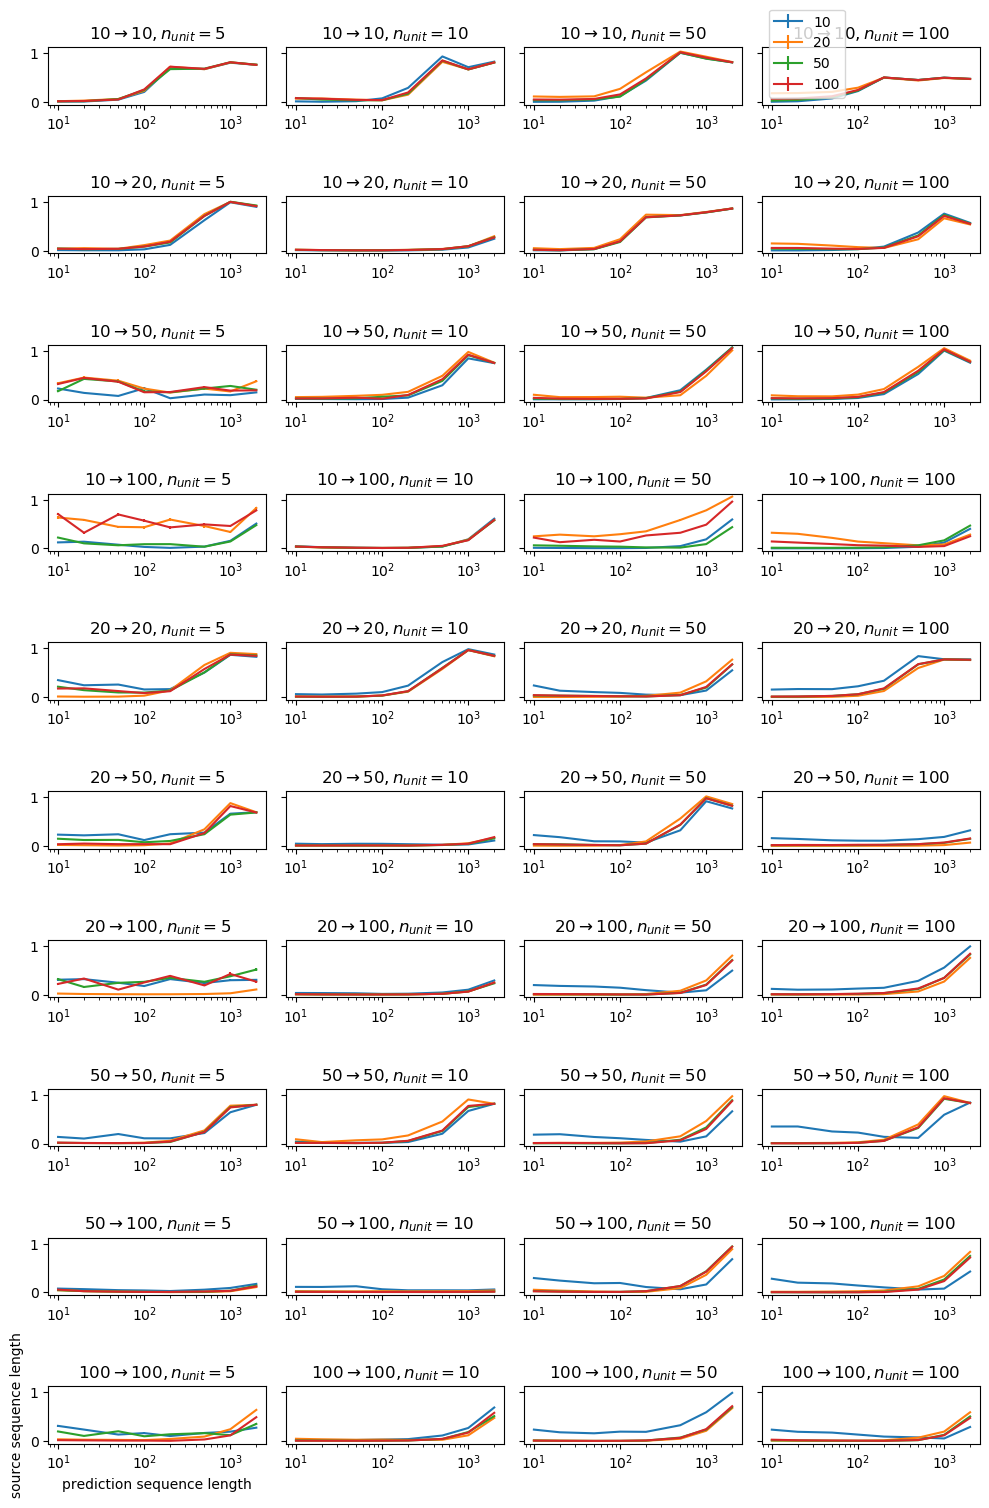

In [59]:
f_pred_result,ax = plt.subplots(len(model_param_sort_list),len(n_unit_list),figsize=(10,15),dpi=100,tight_layout=True,sharey=True)
norm = plt.Normalize(vmin = pred_err.min(), vmax=pred_err.max())
for model_idx, (src_train, trg_train) in enumerate(model_param_sort_list):
    for nu_idx, n_units in enumerate(n_unit_list):
        ax_ = ax[model_idx,nu_idx]
#         ax_.imshow(pred_err[model_idx,nu_idx,:,:,:].mean(axis=-1),cmap='jet',aspect='auto',norm=norm)
#         ax_.set_xticks(np.arange(len(test_n_trg_list)))
#         ax_.set_xticklabels(test_n_trg_list)
#         ax_.set_yticks(np.arange(len(test_n_src_list)))
#         ax_.set_yticklabels(test_n_src_list)
#         ax_.set_title('${} \\rightarrow {}, n_{{unit}} = {}$'.format(src_train,trg_train,n_units))
        r_mean = pred_err[model_idx,nu_idx,:,:,:].mean(axis=-1).T
        r_err = pred_err[model_idx,nu_idx,:,:,:].std(axis=-1).T/n_trial
        for n_src_idx, n_src in enumerate(test_n_src_list):
            ax_.errorbar(test_n_trg_list,r_mean[:,n_src_idx],yerr=r_err[:,n_src_idx],label='{}'.format(n_src))
        ax_.set_title('${} \\rightarrow {}, n_{{unit}}={}$'.format(src_train,trg_train,n_units))
        ax_.set_xscale('log')
ax[-1,0].set_xlabel('prediction sequence length')
ax[-1,0].set_ylabel('source sequence length')
ax[0,-1].legend(loc=0);
f_pred_result.savefig('./variable_output_length_sin/prediction_tests.png')